In [2]:
!sudo apt update
!sudo apt install -y tesseract-ocr


Get:1 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Get:2 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,626 B]
Hit:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:4 http://archive.ubuntu.com/ubuntu jammy InRelease
Ign:5 https://r2u.stat.illinois.edu/ubuntu jammy InRelease
Get:6 https://r2u.stat.illinois.edu/ubuntu jammy Release [5,713 B]
Get:7 https://r2u.stat.illinois.edu/ubuntu jammy Release.gpg [793 B]
Get:8 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:9 http://security.ubuntu.com/ubuntu jammy-security/universe amd64 Packages [1,160 kB]
Get:10 http://security.ubuntu.com/ubuntu jammy-security/main amd64 Packages [2,326 kB]
Hit:11 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Hit:12 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:13 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:14 https://ppa.lau

In [3]:
!pip install pytesseract


In [4]:
import pytesseract

# Specify the tesseract command path
pytesseract.pytesseract.tesseract_cmd = '/usr/bin/tesseract'


In [85]:
!pip install fuzzywuzzy
!pip install python-Levenshtein


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.6/162.6 kB 11.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 53.6 MB/s eta 0:00:00


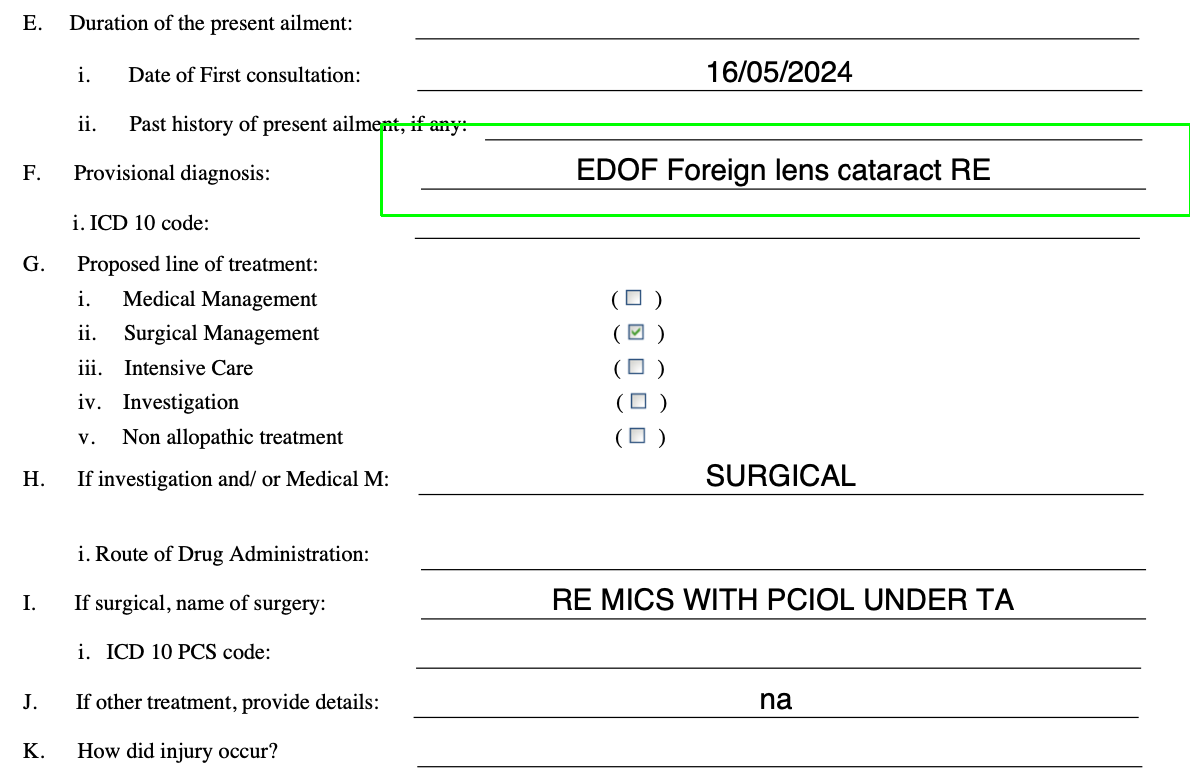

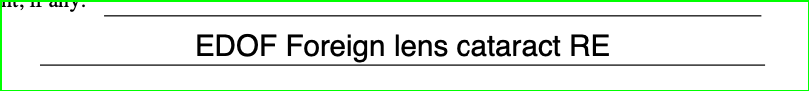

[{'text': 'Duration', 'box': {'x': 69, 'y': 14, 'width': 80, 'height': 17}}, {'text': 'of', 'box': {'x': 154, 'y': 14, 'width': 20, 'height': 17}}, {'text': 'the', 'box': {'x': 178, 'y': 14, 'width': 27, 'height': 17}}, {'text': 'present', 'box': {'x': 210, 'y': 17, 'width': 65, 'height': 18}}, {'text': 'ailment:', 'box': {'x': 280, 'y': 14, 'width': 72, 'height': 16}}, {'text': 'i.', 'box': {'x': 78, 'y': 66, 'width': 12, 'height': 17}}, {'text': 'Date', 'box': {'x': 128, 'y': 67, 'width': 43, 'height': 16}}, {'text': 'of', 'box': {'x': 176, 'y': 66, 'width': 20, 'height': 17}}, {'text': 'First', 'box': {'x': 200, 'y': 66, 'width': 41, 'height': 16}}, {'text': 'consultation:', 'box': {'x': 247, 'y': 66, 'width': 113, 'height': 17}}, {'text': '16/05/2024', 'box': {'x': 708, 'y': 60, 'width': 144, 'height': 23}}, {'text': 'ii,', 'box': {'x': 78, 'y': 115, 'width': 18, 'height': 17}}, {'text': '_', 'box': {'x': 106, 'y': 111, 'width': 21, 'height': 30}}, {'text': 'Past', 'box': {'x': 129

In [94]:
import numpy as np
import cv2
import pytesseract
from google.colab.patches import cv2_imshow
from fuzzywuzzy import fuzz

def preprocess_image(img):
    gray = cv2.cvtColor(np.array(img), cv2.COLOR_BGR2GRAY)
    resized = cv2.resize(gray, None, fx=1, fy=1, interpolation=cv2.INTER_LANCZOS4)
    processed_image = cv2.adaptiveThreshold(
        resized,
        255,
        cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
        cv2.THRESH_BINARY,
        65,
        13
    )
    return processed_image

def extract_text_with_boxes(image_path):
    image = cv2.imread(image_path)
    processed_image = preprocess_image(image)
    data = pytesseract.image_to_data(processed_image, output_type=pytesseract.Output.DICT)

    extracted_data = []
    for i in range(len(data['text'])):
        text = data['text'][i].strip()
        if text:
            extracted_data.append({
                'text': text,
                'box': {
                    'x': data['left'][i],
                    'y': data['top'][i],
                    'width': data['width'][i],
                    'height': data['height'][i]
                }
            })

    return image, extracted_data

def draw_provisional_diagnosis_box_and_extract_rois(image, extracted_data):
    rois = []
    height, width, _ = image.shape
    best_match = None
    highest_ratio = 0
    for item in extracted_data:
        text = item['text']
        box = item['box']

        if is_similar_to_diagnosis(text):
            ratio = fuzz.ratio(text.lower(), "diagnosis")
            if ratio > highest_ratio:
                highest_ratio = ratio
                best_match = item

    if best_match:
        box = best_match['box']
        cv2.rectangle(image,
                      (box['x'] + 200, box['y'] - 40),
                      (width, box['y'] + box['height'] + 30),
                      (0, 255, 0), 2)
        roi = image[box['y']-40:box['y'] + box['height']+30, box['x'] + 200:width]
        rois.append(roi)

    return rois

def is_similar_to_diagnosis(text, threshold=80):
    keywords = ["diagnosis", "provisional diagnosis"]
    for keyword in keywords:
        if fuzz.ratio(text.lower(), keyword) >= threshold:
            return True
    return False

image_path = "/content/Sample7.png"  # Replace with your image path
image, extracted_data = extract_text_with_boxes(image_path)
rois = draw_provisional_diagnosis_box_and_extract_rois(image, extracted_data)

cv2_imshow(image)

for i, roi in enumerate(rois):
    cv2_imshow(roi)
    cv2.imwrite(f"/content/roi_{i}.png", roi)

print(extracted_data)
